In [1]:
from matplotlib import pyplot as plt, style, ticker
from datetime import datetime
import pandas as pd

import requests
from lxml import html, etree
from urllib.parse import quote_plus, urlparse, parse_qs

style.use('ggplot')

In [2]:
# getting html tree from the url
url = "http://www.nasdaq.com/symbol/{stock}/institutional-holdings?page={page}"
stock = "X"
page = requests.get(
    url.format(stock=quote_plus(stock.lower()), page=1)
)
tree = html.fromstring(page.content)
print(tree)
print([e for e in tree])

<Element html at 0xafdf1734>
[<Element head at 0xb469b9dc>, <Element body at 0xafa0b5a4>]


<h4>Let's get the number of pages from the last link in the footer</h4>
<img src="2_footer.png">

In [3]:
pager = tree.find('.//ul[@id="pager"]')
page_links = pager.findall('.//a')
href = page_links[-1].attrib['href']
href

'http://www.nasdaq.com/symbol/x/institutional-holdings?page=23'

In [4]:
parsed_url = urlparse(href)
query_params = parse_qs(parsed_url.query)
max_page = int(query_params['page'][0])
max_page

23

<h4>Now we are ready to get all the data</h4>
<img src="2_table.png">

In [5]:
df = pd.DataFrame([], columns=('Name', 'Date', 'Held', 'Change', 'ChangePercent', 'Value')) # empty
i = 0
for page_num in range(1, max_page + 1):
    
    page = requests.get(
        url.format(stock=quote_plus(stock.lower()), page=page_num)
    )
    tree = html.fromstring(page.content)
    
    blocks = tree.findall('.//div[@id="quotes_content_left_pnlInsider"]')    
    table = blocks[0].getchildren()[0]    
    
    for row in table:
        if row.tag == 'tr':
            df.loc[i] = [col.text_content() for col in row]
            i += 1
df

,Name,Date,Held,Change,ChangePercent,Value
0,VANGUARD GROUP INC,09/30/2016,"14,285,167","3,697,674",34.93,"499,838"
1,BLACKROCK FUND ADVISORS,09/30/2016,"6,193,405","1,025,132",19.84,"216,707"
2,STATE STREET CORP,09/30/2016,"6,192,730","409,509",7.08,"216,684"
3,"BLACKROCK INSTITUTIONAL TRUST COMPANY, N.A.",09/30/2016,"4,903,712","609,503",14.19,"171,581"
4,CITADEL ADVISORS LLC,09/30/2016,"4,563,148","3,918,193",607.51,"159,665"
5,DIMENSIONAL FUND ADVISORS LP,09/30/2016,"4,548,424","622,504",15.86,"159,149"
6,"ARROWSTREET CAPITAL, LIMITED PARTNERSHIP",09/30/2016,"4,063,233","4,063,233",New,"142,173"
7,LUMINUS MANAGEMENT LLC,09/30/2016,"4,016,605","1,643,142",69.23,"140,541"
8,FAIRPOINTE CAPITAL LLC,09/30/2016,"4,003,436","(1,481,097)",(27.01),"140,080"
9,UNITED STATES STEEL & CARNEGIE PENSION FUND,09/30/2016,"3,763,643","3,763,643",New,"131,690"


In [6]:
# everything as a singe function + type conversions of values
def get_institutional_holdings(stock):
    url = "http://www.nasdaq.com/symbol/{stock}/institutional-holdings?page={page}"
    page = requests.get(
        url.format(stock=quote_plus(stock.lower()), page=1)
    )
    tree = html.fromstring(page.content)
    # get pager
    pager = tree.find('.//ul[@id="pager"]')
    page_links = pager.findall('.//a')
    href = page_links[-1].attrib['href']

    # get the max page number from the last link
    parsed_url = urlparse(href)
    query_params = parse_qs(parsed_url.query)
    max_page = int(query_params['page'][0])

    # pull data from every page
    df = pd.DataFrame([], columns=('Name', 'Date', 'Held', 'Change', 'ChangePercent', 'Value'))
    
    def to_int(val):
        return int(val.strip('()').replace(',', '')) if val else 0

    i = 0
    for page_num in range(1, max_page + 1):

        page = requests.get(
            url.format(stock=quote_plus(stock.lower()), page=page_num)
        )
        tree = html.fromstring(page.content)

        blocks = tree.findall('.//div[@id="quotes_content_left_pnlInsider"]')
        table = blocks[0].getchildren()[0]
        
        for row in table:
            if row.tag == 'tr':
                raw_values = [col.text_content().strip() for col in row]
                name = raw_values[0]
                date = datetime.strptime(raw_values[1], "%m/%d/%Y").date()
                held = to_int(raw_values[2])
                decreased = raw_values[3].startswith('(')
                change = to_int(raw_values[3]) * (-1) ** decreased
                percent = raw_values[4]
                value = to_int(raw_values[5])

                df.loc[i] = (name, date, held, change, percent, value)
                i += 1
    return df
            
df = get_institutional_holdings('X')
df

,Name,Date,Held,Change,ChangePercent,Value
0,VANGUARD GROUP INC,2016-09-30,14285167.0,3697674.0,34.93,499838.0
1,BLACKROCK FUND ADVISORS,2016-09-30,6193405.0,1025132.0,19.84,216707.0
2,STATE STREET CORP,2016-09-30,6192730.0,409509.0,7.08,216684.0
3,"BLACKROCK INSTITUTIONAL TRUST COMPANY, N.A.",2016-09-30,4903712.0,609503.0,14.19,171581.0
4,CITADEL ADVISORS LLC,2016-09-30,4563148.0,3918193.0,607.51,159665.0
5,DIMENSIONAL FUND ADVISORS LP,2016-09-30,4548424.0,622504.0,15.86,159149.0
6,"ARROWSTREET CAPITAL, LIMITED PARTNERSHIP",2016-09-30,4063233.0,4063233.0,New,142173.0
7,LUMINUS MANAGEMENT LLC,2016-09-30,4016605.0,1643142.0,69.23,140541.0
8,FAIRPOINTE CAPITAL LLC,2016-09-30,4003436.0,-1481097.0,(27.01),140080.0
9,UNITED STATES STEEL & CARNEGIE PENSION FUND,2016-09-30,3763643.0,3763643.0,New,131690.0


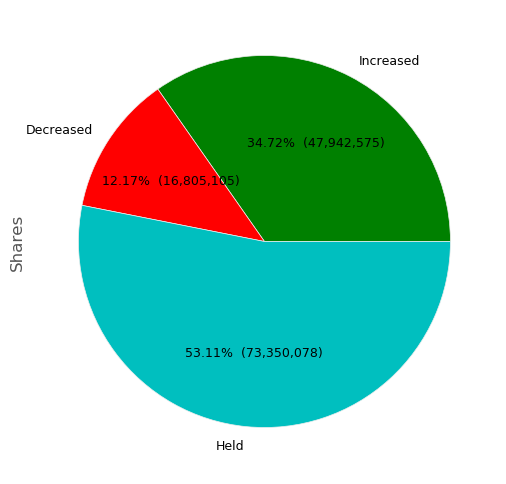

,Count,Shares
Increased,195.0,47942574.0
Decreased,101.0,16805106.0
Held,42.0,73350077.0


In [7]:
# prepare dataframe
active_df = pd.DataFrame([], columns=('Count', 'Shares'))

inc_holders = df[df.Change > 0]
active_df.loc['Increased'] = len(inc_holders), inc_holders.Change.sum()

decr_holders = df[df.Change < 0]
active_df.loc['Decreased'] = len(decr_holders), abs(decr_holders.Change.sum())

held_holders = df[df.Change == 0]
active_df.loc['Held'] = len(held_holders), df.Held.sum() - active_df['Shares'].sum()

# it's just to show values and percents on the chart
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:,})'.format(p=pct,v=val)
    return my_autopct

# plot dataframe
active_df.Shares.plot.pie(figsize=(6, 6), colors=['g', 'r', 'c'], 
                          autopct=make_autopct(active_df.Shares), fontsize=9)
plt.show()

active_df

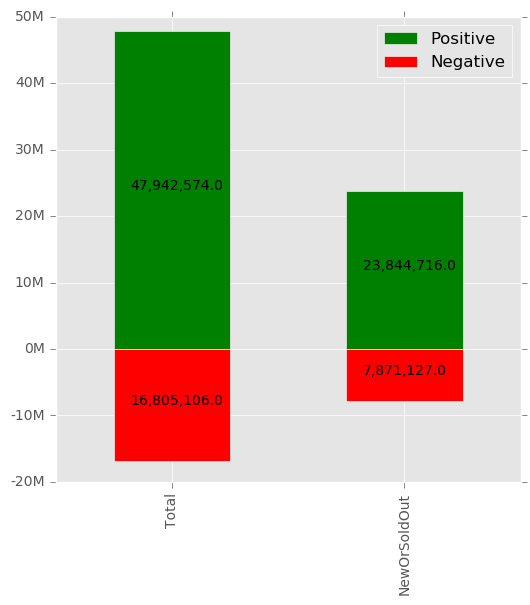

,Positive,Negative
Total,47942574.0,-16805106.0
NewOrSoldOut,23844716.0,-7871127.0


In [8]:
# prepare dataframe for plotting
new_sold_df = pd.DataFrame([], columns=('Positive', 'Negative'))

new_sold_df.loc['Total'] = active_df.loc['Increased']['Shares'], active_df.loc['Decreased']['Shares'] * (-1)

new = df[df.ChangePercent == 'New']
sold = df[df.ChangePercent == 'Sold Out']
new_sold_df.loc['NewOrSoldOut'] = new.Change.sum(), sold.Change.sum()

# plot data
ax = new_sold_df.plot.bar(figsize=(6, 6), color=['g', 'r'], stacked=True)

# format axis, show values
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: "%dM" % (x / 1000000)))
for i, label in enumerate(list(new_sold_df.index)):
    pos_score = new_sold_df.ix[label]['Positive']
    ax.annotate('{:,}'.format(pos_score), (i - .18, pos_score * .5))
    neg_score = new_sold_df.ix[label]['Negative']
    ax.annotate('{:,}'.format(abs(neg_score)), (i - .18, neg_score * .5))
    
plt.show()

new_sold_df